# Generative Model Tutorial

In this lecture you'll learn:

* How to build generative models that take into account knowledge we have about the data generation process
* How can apply Bayes formula to reason backwards from observed data to unobservable hidden causes
* How to model time-varying processes
* How to iteratively improve a model

This notebooks explains the model powering https://rt.live with its nowcast of the effective reproduction number. It is based on [version 1.0.0](https://github.com/rtcovidlive/covid-model/commit/50bf8e4ace5b973b3d323f058ad613d4b02f4c2f) of the model.

## What is Rt?
$R_0$ ("R-naught") describes the reproduction factor of a disease -- i.e. how many other people does one infected person pass the disease to. If this quantity is larger than 1 we have an epidemic on our hands, as is the case for COVID-19. 

$R_0$ assumes, however, that there are no counter-measures being implemented to curb spread of the virus. Thus, the more critical measure to track is $R_e(t)$ -- the time-changing effective reproduction factor, i.e. on a given day $t$, how many people does one person infect. 

As lockdowns and social distancing measures are put in place we expect this quantity to drop, ideally below the critical quantity of 1 because then, over time, the disease would just wimper out.

Usually we'd extract $R_e(t)$ from something like an [SIR (susceptible-infected-recovered) model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology) or an SEIR (which adds an exposed category), which are classic epidemiological compartment models. 

An SIR model is in fact what `rt.live` used in the beginning. However, SIR/SEIR models are also just approximations of the real thing and come with quite a few assumptions baked in. The current model is simpler and makes fewer assumptions. In addition, the SIR model is described as an ODE which causes various technical problems. Solving the ODE is quite time-intensive and while closed-form approximations exist and are faster, we found that they are quite unreliable.

Instead, the current model uses a simple generative logic to explain how a initial pool of infected people spreads the disease at each time-point, according to the current reproduction factor.

## The generative model

We need the package from the rtlive repo to download data and get our distributions.

In [10]:
!pip install --no-deps -e git+https://github.com/twiecki/covid-model.git@setuppy#egg=rtlive

Obtaining rtlive from git+https://github.com/twiecki/covid-model.git@setuppy#egg=rtlive
  Updating ./src/rtlive clone (to revision setuppy)
  Running command git fetch -q --tags
  Running command git reset --hard -q 525cfe804a0f03186bd52a456102997dcc0f8486
  Running setup.py develop for rtlive


In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pymc3 as pm
import arviz as az
import theano
import theano.tensor as tt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_context('talk')
from scipy import stats
from matplotlib import pyplot as plt
import load_covid_data

# This requires the package
from covid.models.generative import GenerativeModel
from covid.patients import get_delay_distribution
from covid.data import summarize_inference_data, get_and_process_covidtracking_data
%config InlineBackend.figure_format = 'retina'

# There is a bug in the prior sampling of the GaussianRandomWalk,
# this monkey-patches a fix. This should be fixed soon in PyMC3.
def _random(self, sigma, mu, size, sample_shape):
    """Implement a Gaussian random walk as a cumulative sum of normals."""
    if size[len(sample_shape)] == sample_shape:
        axis = len(sample_shape)
    else:
        axis = len(size) - 1
    rv = stats.norm(mu, sigma)
    data = rv.rvs(size).cumsum(axis=axis)
    data = np.array(data)
    if len(data.shape)>1:
        for i in range(data.shape[0]):
            data[i] = data[i] - data[i][0]
    else:
        data = data - data[0]
    return data

pm.GaussianRandomWalk._random = _random

sampler_kwargs = {"chains": 4, "cores": 4, "return_inferencedata": True}

df = load_covid_data.load_data(drop_states=True, filter_n_days_100=2)
countries = df.country.unique()
n_countries = len(countries)
df = df.loc[lambda x: (x.days_since_100 >= 0)]
df['new_cases'] = df.confirmed.diff()
df.head()

,country,state,type,confirmed,critical_estimate,days_since_100,deaths,new_cases
date,,,,,,,,
2020-03-27,Afghanistan,NaN,confirmed,110,5.5,0.0,4,NaN
2020-03-28,Afghanistan,NaN,confirmed,110,5.5,1.0,4,0.0
2020-03-29,Afghanistan,NaN,confirmed,120,6.0,2.0,4,10.0
2020-03-30,Afghanistan,NaN,confirmed,170,8.5,3.0,4,50.0
2020-03-31,Afghanistan,NaN,confirmed,174,8.7,4.0,4,4.0


While before we looked at cumulative confirmed cases, it makes more sense to look at new daily cases. This also gets around the problem that our previous models all allowed cases to also go down over time, while the data generating process did not allow that.

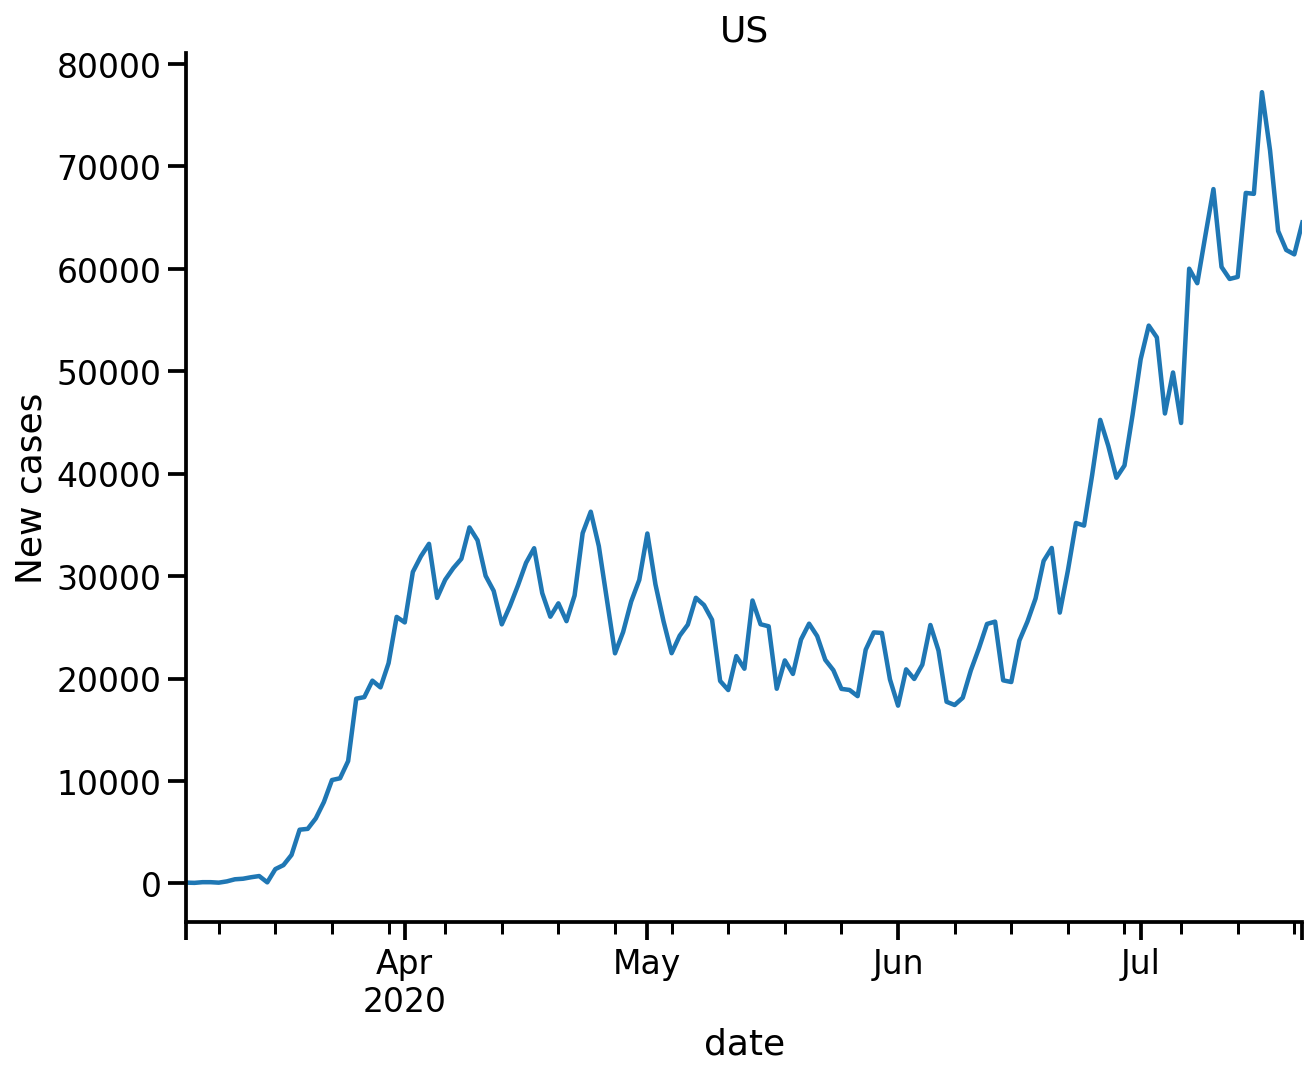

In [2]:
country = 'US'
df_country = df.loc[lambda x: (x.country == country)].iloc[1:]

fig, ax = plt.subplots(figsize=(10, 8))
new_cases = df_country.new_cases
new_cases.plot(ax=ax)
ax.set(ylabel='New cases', title=country)
sns.despine()

Let's assume that for an idealized disease we start with a single infected patient (primary infection) on day $0$ that is infectous for a single day only and on that day goes on to infect 2 people (secondary infection) which become sick the next day. This disease thus has a reproduction factor $R_0$ of 2. We could write that on day $t$ the number of newly infected $y_t$ is:

$$ y_t = y_{t-1} \cdot R_0 $$

Quite simple. This logic gives rise to the classic exponential growth pattern we see in epidemics:

In [3]:
# Code optimized for readability, not speed
n_days = 10
ts = np.arange(n_days)
R0 = 2
y = np.zeros(n_days) 

y[0] = 1 # starting with 1 infected
for t in ts[1:]:
    y[t] = y[t-1] * R0

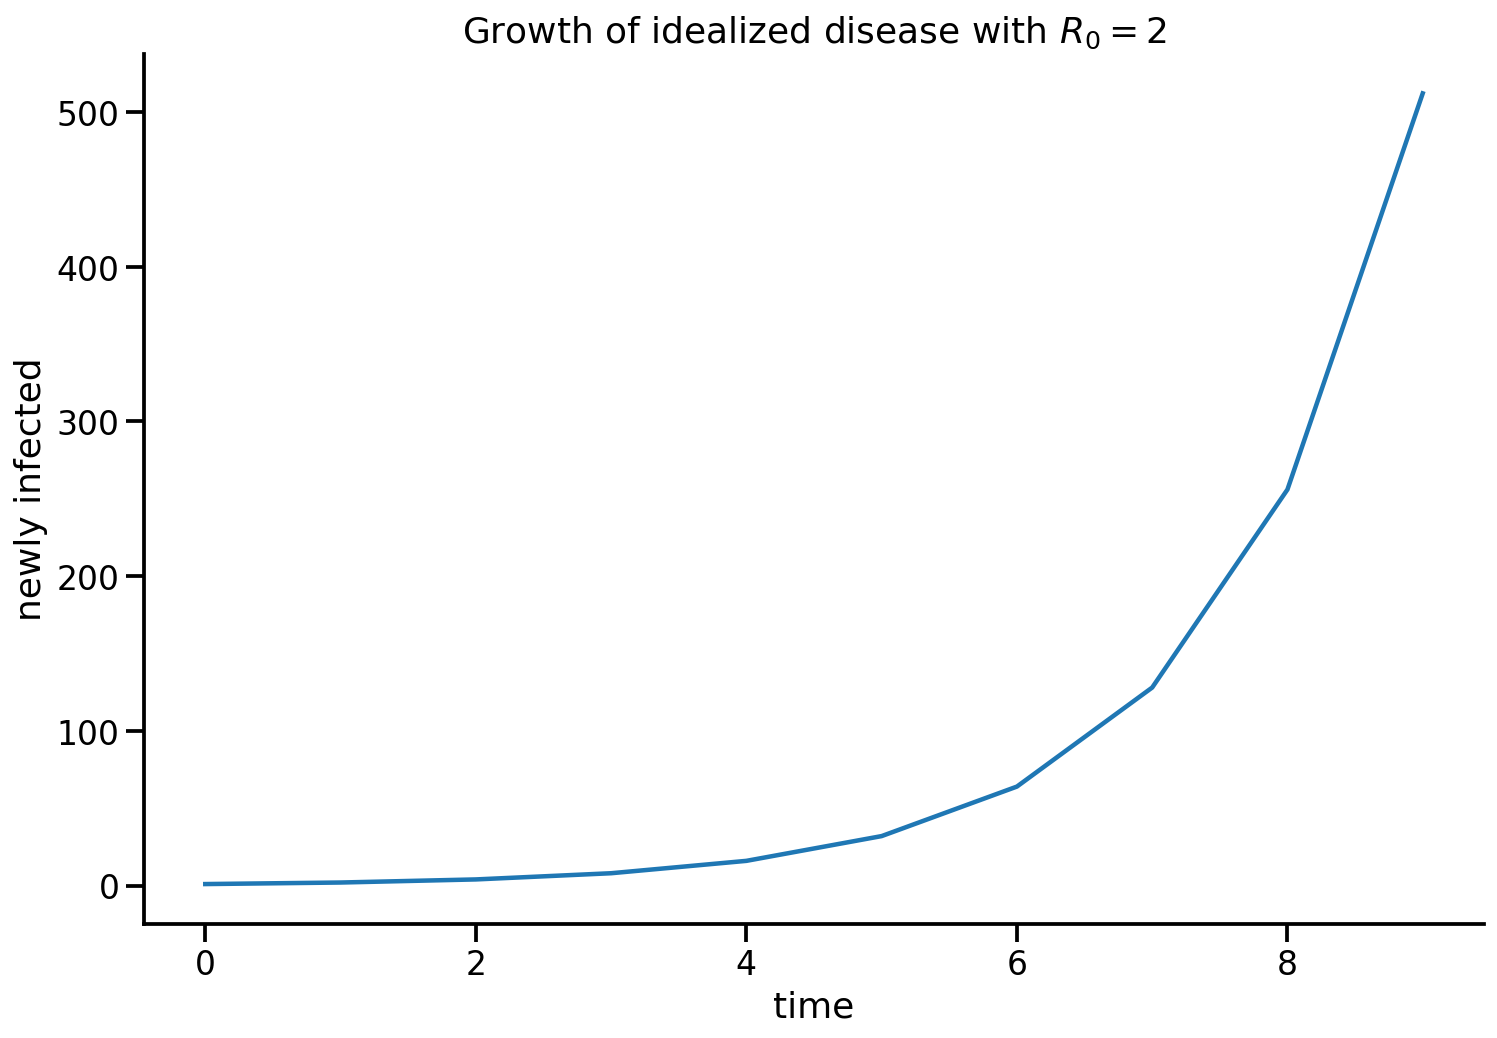

In [4]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, y);
ax.set(xlabel='time', ylabel='newly infected', 
       title='Growth of idealized disease with $R_0 = 2$'); sns.despine();

## Building a model

In order to build this recursive nature into `PyMC3` we need to loop inside our model. Because PyMC3 compiles everything to `theano` we can't just use a Python loop. Fortunately, `theano` has its own looping logic in the form of `scan`. Unfortunately, the syntax is quite confusing. Do not worry about all the individual arguments too much, but see that our generative logic is implemented as a lambda function passed to `fn`. `scan` will then loop through `sequences` and update `y` in every iteration.

Here we also make use of `Deterministic` for the first time. All that does is to save a variable of your model in the trace. If you have any expression consisting of other random variables it's often convenient to record them along with the parameter posteriors.

In [143]:
len_observed = len(new_cases)

with pm.Model() as model_r0:
    # r0 can only be positive
    r0 = pm.Lognormal("r0", np.log(.2), .1)
    
    # Define a seed population
    seed = pm.Exponential("seed", 0.01)
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    # Apply the recursive algorithm from above
    outputs, _ = theano.scan(
        fn=lambda t, y, r0: tt.set_subtensor(y[t], tt.sum(r0 * y)),
        sequences=[tt.arange(1, len_observed)],
        outputs_info=y0,
        non_sequences=r0,
        n_steps=len_observed - 1,
    )
    infections = pm.Deterministic("infections", outputs[-1])
    
    # Stop infections from taking on unreasonably large values that break
    # the NegativeBinomial
    infections = tt.clip(infections, 0, 10_000_000)
    
    # Likelihood
    pm.NegativeBinomial(
        'obs',
         infections,
         alpha=pm.Gamma("alpha", mu=6, sigma=1),
         observed=new_cases)

In [144]:
with model_r0:
    prior_pred_r0 = pm.sample_prior_predictive()

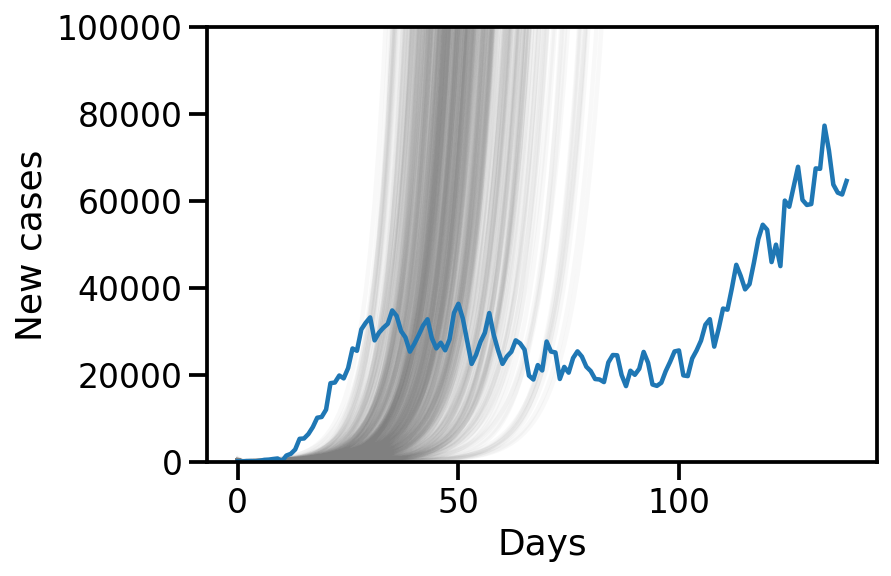

In [145]:
plt.plot(prior_pred_r0["infections"].T, color="0.5", alpha=.05);
plt.plot(new_cases.values);
plt.ylim(0, 100_000); plt.xlabel('Days'); plt.ylabel("New cases");

In [147]:
with model_r0:
    trace = pm.sample(chains=1, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, seed, r0]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 62 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


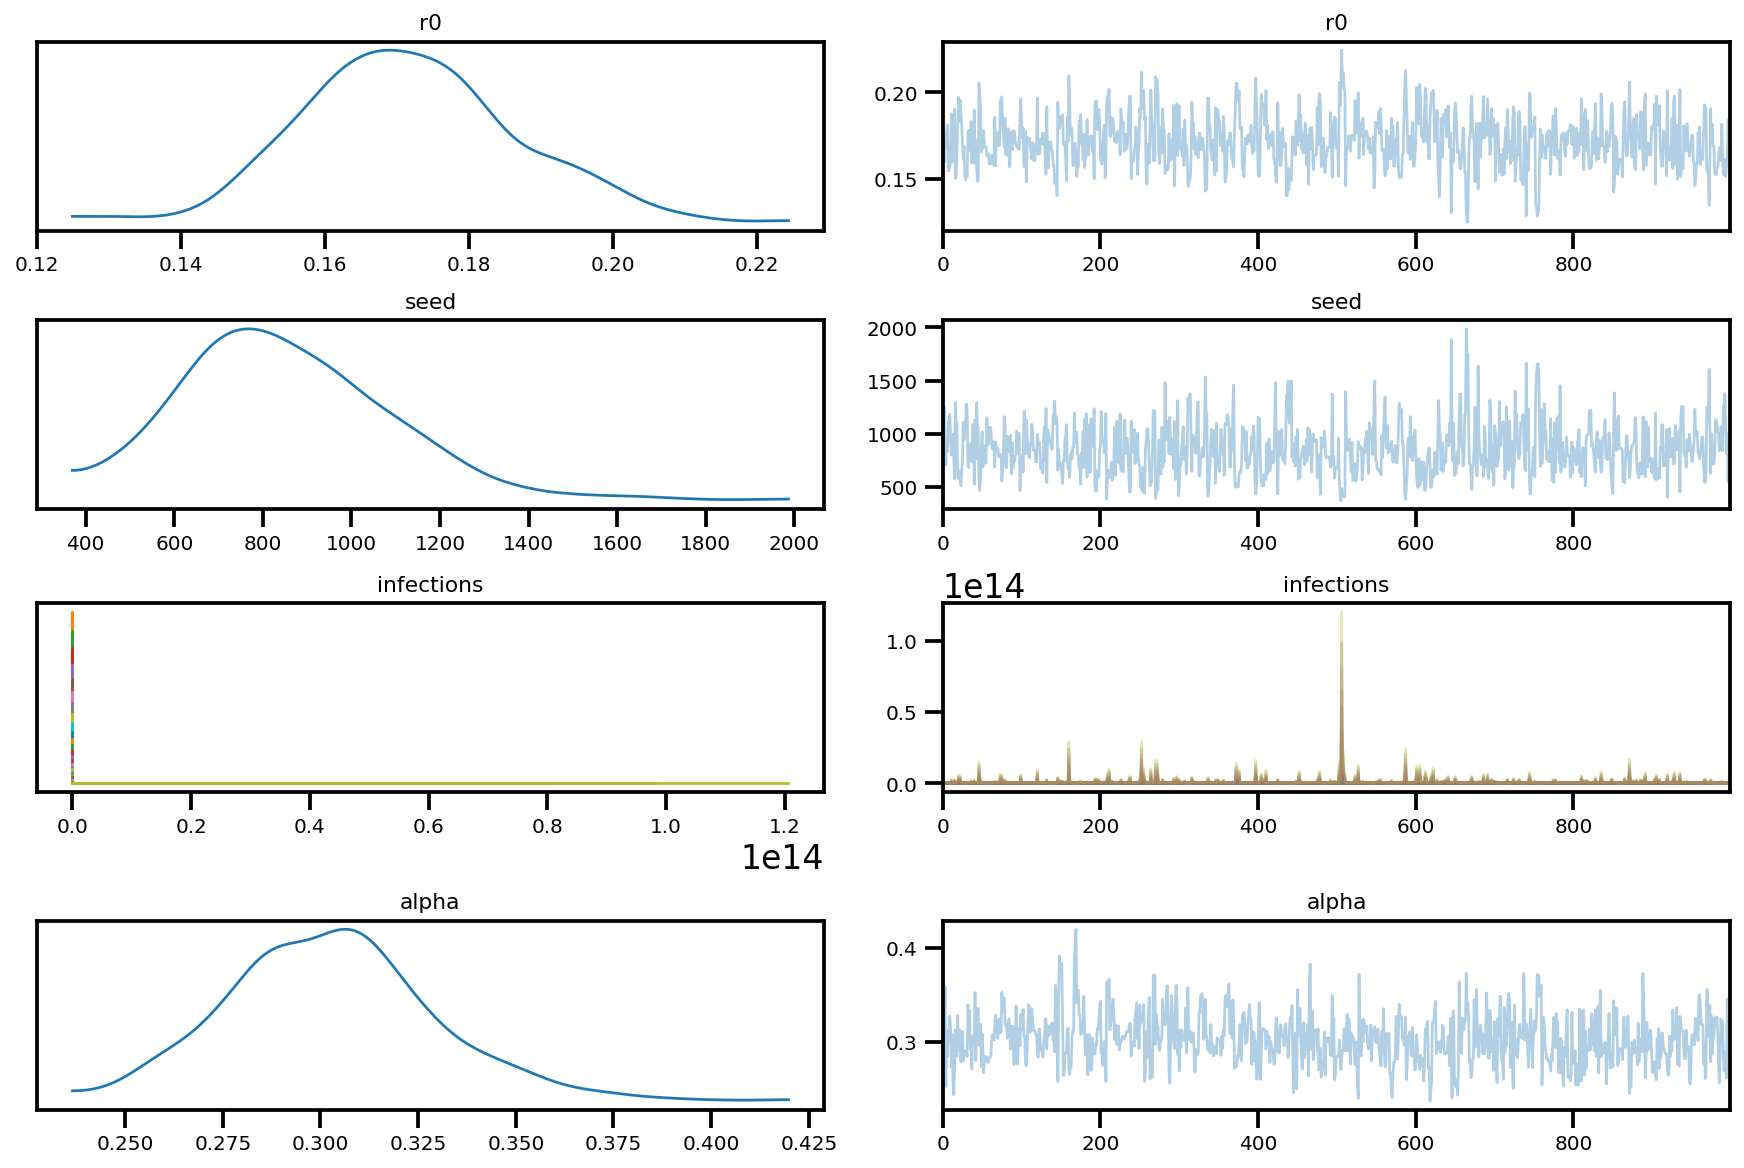

In [148]:
az.plot_trace(trace, compact=True);

In [149]:
with model_r0:
    post_pred = pm.sample_posterior_predictive(trace)

## Time-varying reproduction

However, as we discussed we care more about the effective reproduction rate as a function of time $R_e(t)$. We can just switch that into our idealized generative model:

$$ y_t = y_{t-1} \cdot R_e(t) $$

In [9]:
n_days = 10
ts = np.arange(n_days)
Rt = np.linspace(2, 1, n_days) # Assuming Re(t) goes from 2 to 1
y = np.zeros(n_days)

y[0] = 1 # starting with 1 infected
for t in ts[1:]:
    y[t] = y[t-1] * Rt[t]

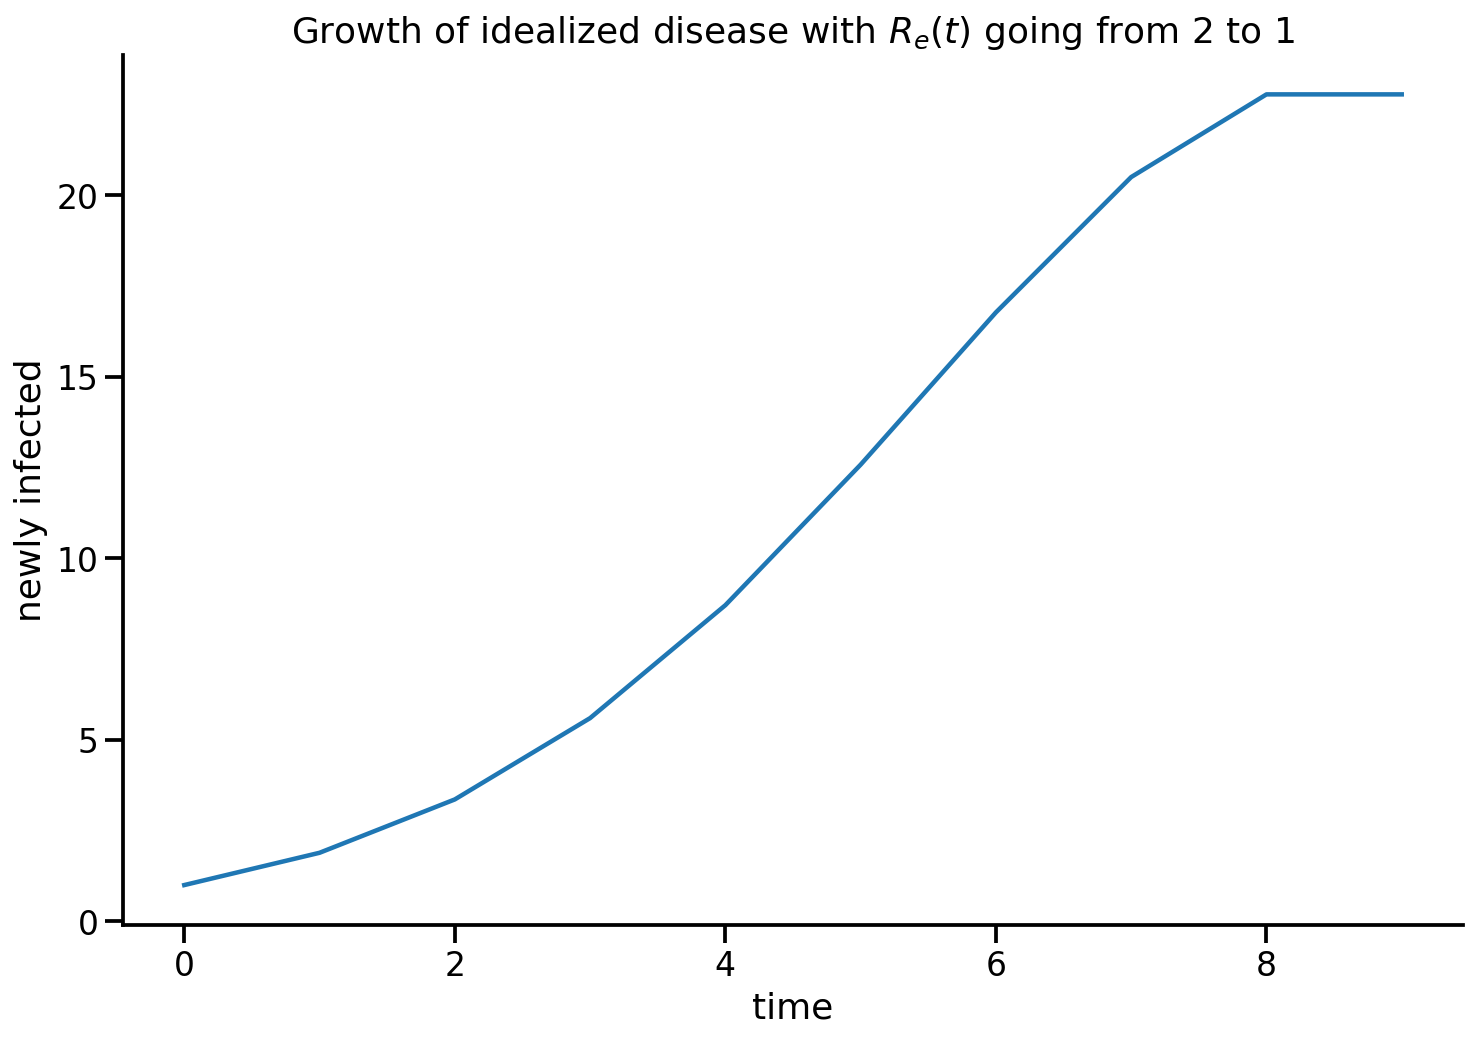

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, y);
ax.set(xlabel='time', ylabel='newly infected', 
       title='Growth of idealized disease with $R_e(t)$ going from 2 to 1'); 
sns.despine();

You can see that on the last day, where $R_e(t)$ is 1 we get the same number of newly infected as on the previous day, because every infected infects just one more person.

The implicit assumption in the generative process above is that an infected person is only infectious for a single day and that it then takes just one day to infect other people.

### Building a model

What type of prior would set for this time-varying reproduction factor $R_e(t)$? The prior information we do have is that it won't change dramatically from one day to the next. We encode this information with a *random-walk prior*:

$$ R_e(t) \sim \mathcal{N}(R_e(t-1), \sigma) $$

where $\sigma$ controls the step-width of the random-walk. Fortunately we already have this distribution included in PyMC3. As we know that the reproduction-factor can only be positive, we take the `exp` of the unconstrained random-walk (which will then be in log-space) to make it positive.

The model thus becomes:

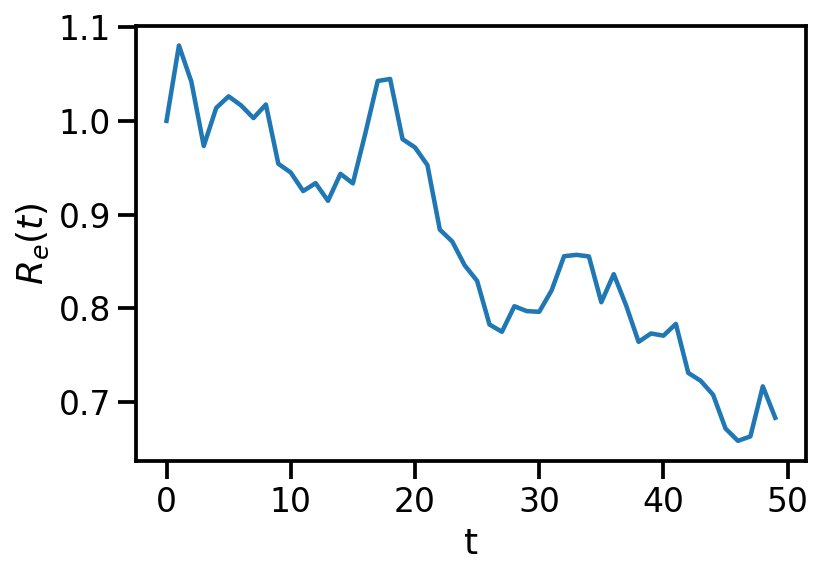

In [18]:
# Generative process in log-space
N = 50
r_log = np.zeros(N)
sigma = .035
for i in range(1, N):
    r_log[i] = stats.norm(r_log[i-1], sigma).rvs()

r = np.exp(r_log)
plt.plot(r)
plt.ylabel("$R_e(t)$")
plt.xlabel("t");

In [19]:
with pm.Model() as model_r_t:
    log_r_t = pm.GaussianRandomWalk(
        "log_r_t",
        sigma=0.035,
        shape=len_observed
    )
    r_t = pm.Deterministic("r_t", pm.math.exp(log_r_t))

    seed = pm.Exponential("seed", 0.01)
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    outputs, _ = theano.scan(
        fn=lambda t, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t * y)),
        sequences=[tt.arange(1, len_observed)],
        outputs_info=y0,
        non_sequences=r_t,
        n_steps=len_observed - 1,
    )
    infections = pm.Deterministic("infections", outputs[-1])
    
    infections = tt.clip(infections, 0, 10_000_000)
    
    # Likelihood
    pm.NegativeBinomial(
        'obs',
        infections,
        alpha=pm.Gamma("alpha", mu=6, sigma=1),
        observed=new_cases)

NameError: name 'len_observed' is not defined

(0.0, 100000.0)

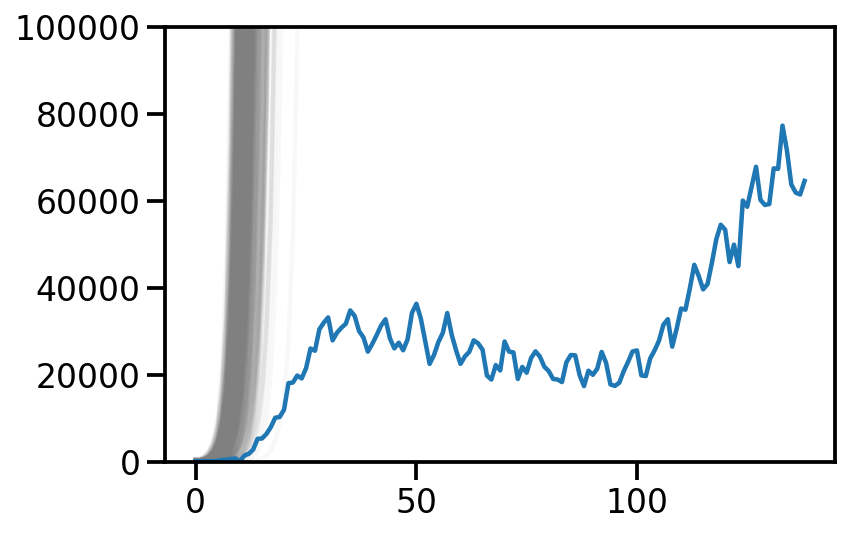

In [102]:
with model_r_t:
    prior_pred = pm.sample_prior_predictive()

plt.plot(prior_pred["infections"].T, color="0.5", alpha=.05);
plt.plot(new_cases.values);
plt.ylim(0, 100_000)

In [12]:
with model_r_t:
    trace = pm.sample(**sampler_kwargs)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 32599 seconds.
The number of effective samples is smaller than 25% for some parameters.


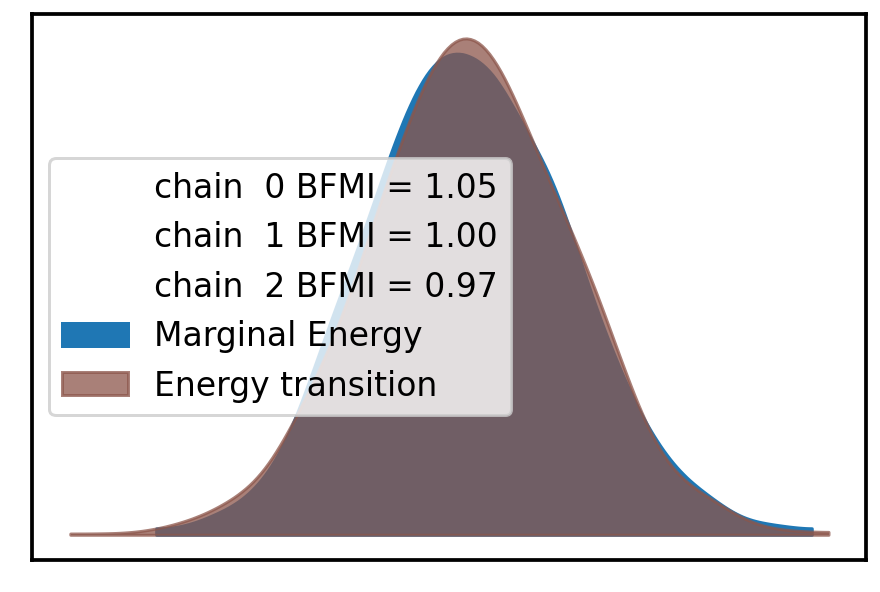

In [103]:
az.plot_energy(trace);

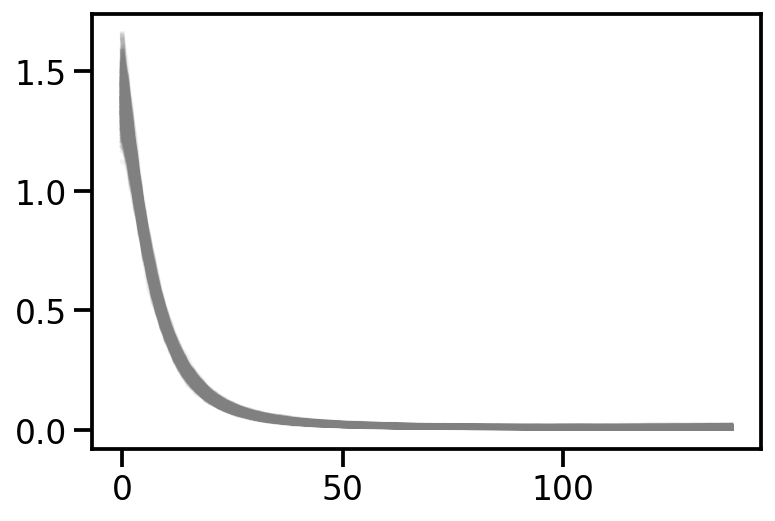

In [118]:
post_rt = trace.posterior["r_t"].sel(chain=0).to_dataframe()['r_t'].unstack().T

plt.plot(post_rt, color="0.5", alpha=.1);

/Users/twiecki/miniconda3/envs/bayes_course/lib/python3.7/site-packages/pymc3/sampling.py:1618: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


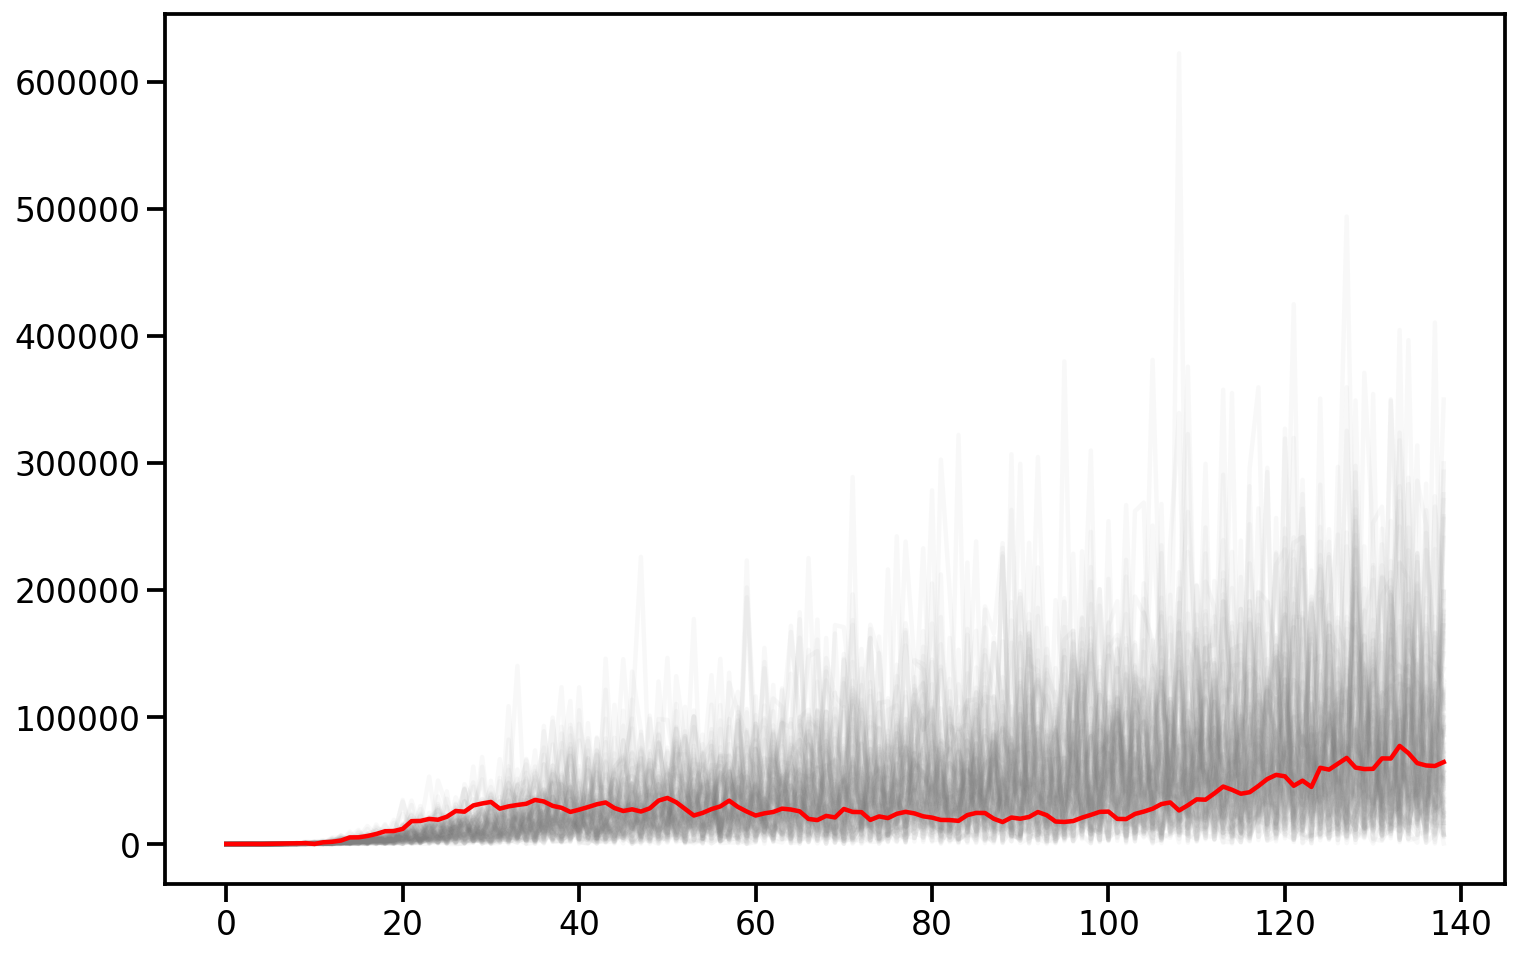

In [117]:
with model_r_t:
    post_pred_r_t = pm.sample_posterior_predictive(trace.posterior, samples=100)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(post_pred_r_t["obs"].T, color="0.5", alpha=.05);
ax.plot(new_cases.values, color="r");

## Taking infection-delay into account

In reality, the time it takes for the primary person to infect others follows a distribution. They might infect one person the next day, two the day after etc. This delay distribution is officially known as the "*generation time*" and we will model it with a probability distribution from [this study](https://www.ijidonline.com/article/S1201-9712(20)30119-3/pdf) (the study actually provides an estimate for something closely related to the generation time but it's fine to use it for this).

The paper includes a simple formulation of how to derive the generation time distribution for COVID-19:

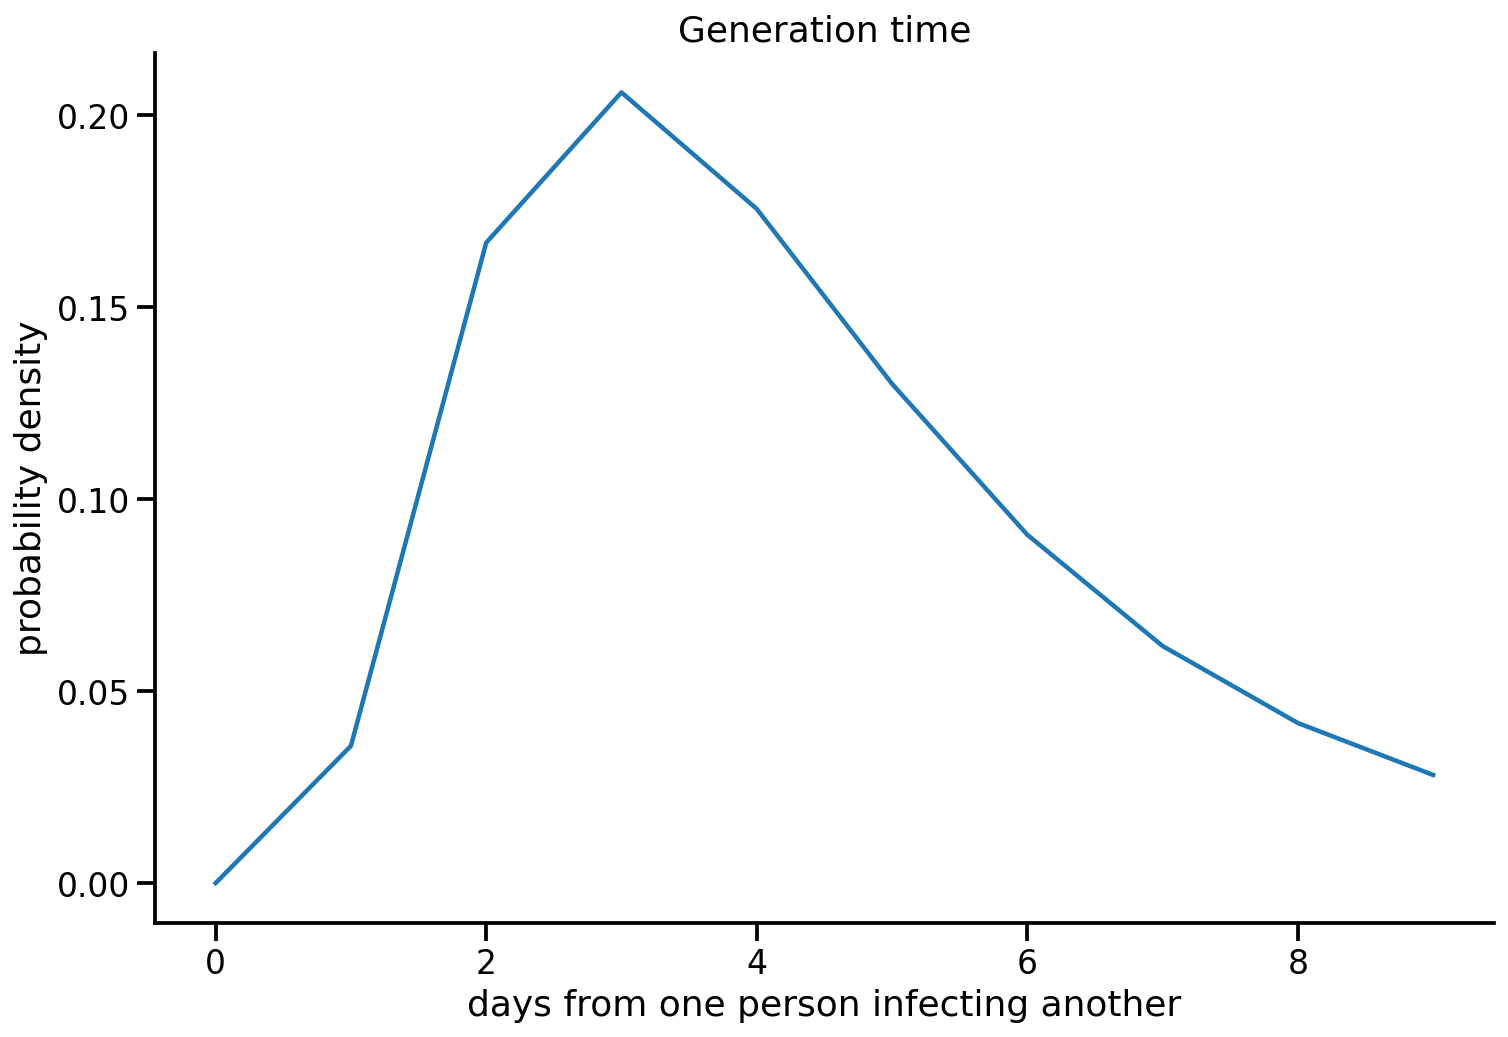

In [13]:
mean_si = 4.7
std_si = 2.9
mu_si = np.log(mean_si ** 2 / np.sqrt(std_si ** 2 + mean_si ** 2))
sigma_si = np.sqrt(np.log(std_si ** 2 / mean_si ** 2 + 1))
generation_time = stats.lognorm(scale=np.exp(mu_si), s=sigma_si)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, generation_time.pdf(ts))
ax.set(xlabel='days from one person infecting another',
       ylabel='probability density',
       title='Generation time'); sns.despine();

In order to include this effect in our generative model we need to do a convolution. Intuitively, instead of the new cases on day $t$ depending only on the new cases on day $t-1$, they now depend on the new cases on (potentially) all previous days because it could have taken 5 days between the time a person got infected and infected another person. We need to take all of these previously infected people into account and by which probability they infect people today. 

We accomplish this by weighting the number of newly infected people $i$ days ago -- $y_{t-i}$ -- by the generation time $g_i$ for that particular delay as well as the effective reproduction number on that day $R_e(t-i)$:

$$ y_t = \sum_{i=1}^{M}y_{t-i} R_e(t-i) g_i  $$

For further details on this generative process see this post: https://staff.math.su.se/hoehle/blog/2020/04/15/effectiveR0.html.

Updating our generative process model accordingly we get:

In [24]:
n_days = 30
ts = np.arange(0, n_days)
Rt = np.linspace(2, 1, n_days) # Assuming Re(t) goes from 2 to 1
y = np.zeros(n_days) 
y[0] = 1 # starting with 1 infected

for t in ts[1:]:
    # loop over previous days
    for i in range(1, t+1):
        y[t] += y[t - i] * Rt[t - i] * generation_time.pdf(i)

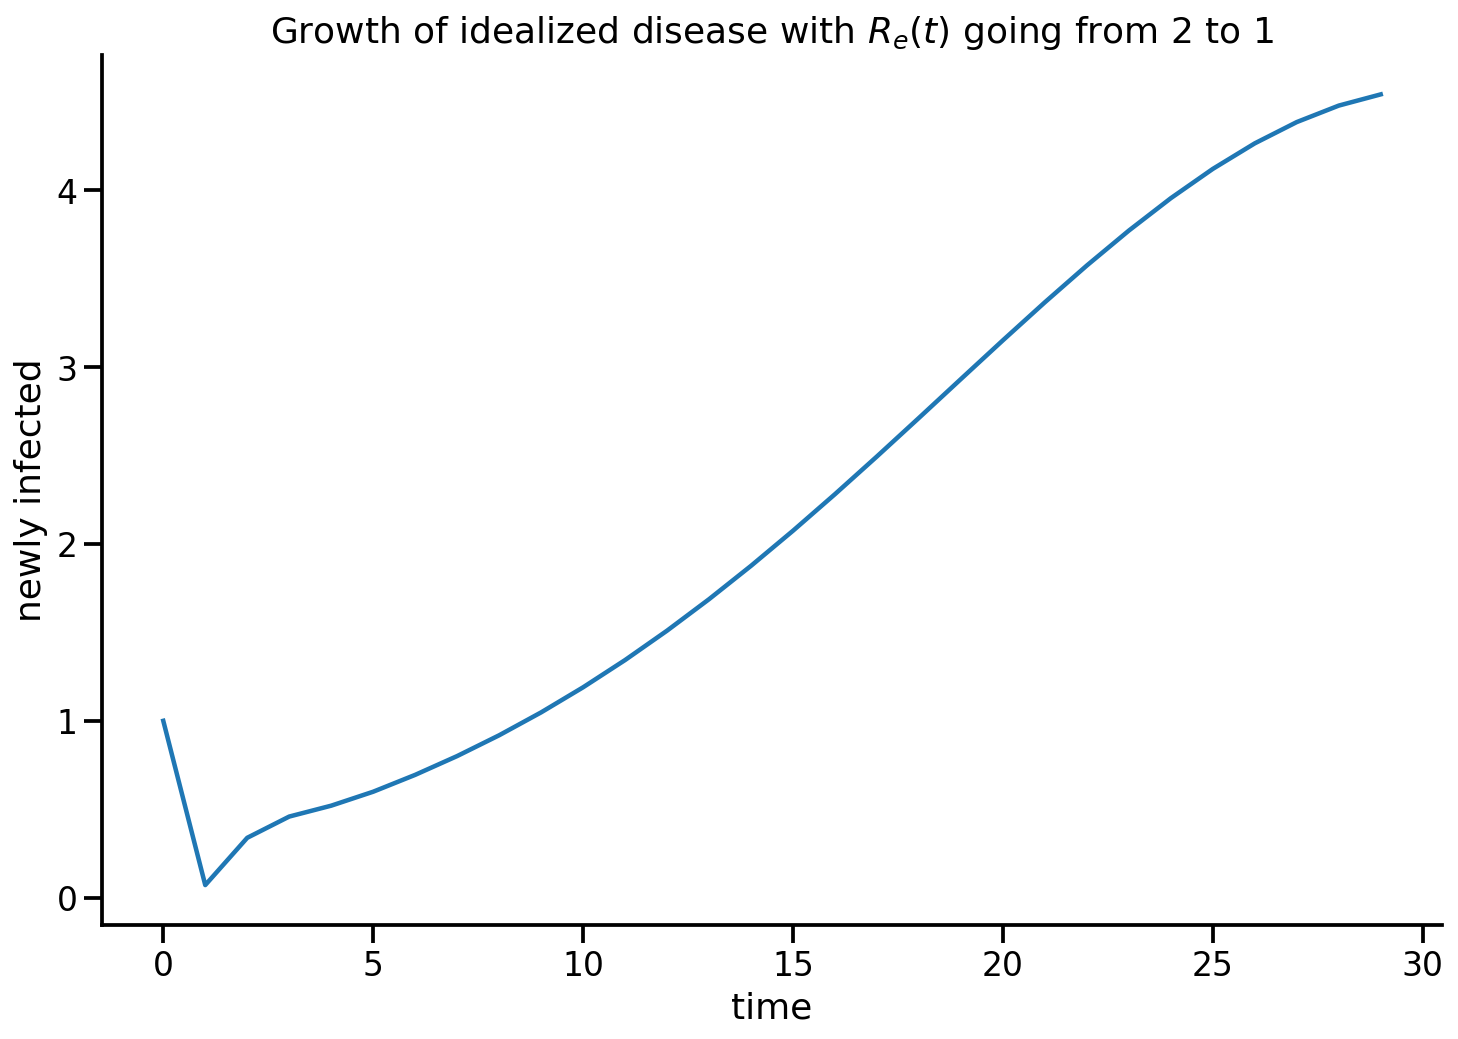

In [25]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, y);
ax.set(xlabel='time', ylabel='newly infected', 
       title='Growth of idealized disease with $R_e(t)$ going from 2 to 1');
sns.despine();

As you can see, taking the delay between one person passing the disease onto the next into account slows the spread significantly. The longer the *generation time*, the slower the spread.

Unfortunately things get a bit technical here, don't worry too much about the individual code but trust that we include the generation time now in our recursive `scan` function.

In [26]:
def _get_generation_time_interval():
    """ Create a discrete P(Generation Interval)
        Source: https://www.ijidonline.com/article/S1201-9712(20)30119-3/pdf """
    import scipy.stats as sps
    mean_si = 4.7
    std_si = 2.9
    mu_si = np.log(mean_si ** 2 / np.sqrt(std_si ** 2 + mean_si ** 2))
    sigma_si = np.sqrt(np.log(std_si ** 2 / mean_si ** 2 + 1))
    dist = sps.lognorm(scale=np.exp(mu_si), s=sigma_si)

    # Discretize the Generation Interval up to 20 days max
    g_range = np.arange(0, 20)
    gt = pd.Series(dist.cdf(g_range), index=g_range)
    gt = gt.diff().fillna(0)
    gt /= gt.sum()
    gt = gt.values
    return gt
    
def _get_convolution_ready_gt(len_observed):
    """ Speeds up theano.scan by pre-computing the generation time interval
        vector. Thank you to Junpeng Lao for this optimization.
        Please see the outbreak simulation math here:
        https://staff.math.su.se/hoehle/blog/2020/04/15/effectiveR0.html """
    gt = _get_generation_time_interval()
    convolution_ready_gt = np.zeros((len_observed - 1, len_observed))
    for t in range(1, len_observed):
        begin = np.maximum(0, t - len(gt) + 1)
        slice_update = gt[1 : t - begin + 1][::-1]
        convolution_ready_gt[
            t - 1, begin : begin + len(slice_update)
        ] = slice_update
    convolution_ready_gt = theano.shared(convolution_ready_gt)
    return convolution_ready_gt

In [48]:
convolution_ready_gt = _get_convolution_ready_gt(len_observed)

with pm.Model() as model_r_t_infection_delay:
    log_r_t = pm.GaussianRandomWalk(
        "log_r_t",
        sigma=0.035,
        shape=len_observed,
        #dims=["date"]
    )
    r_t = pm.Deterministic("r_t", pm.math.exp(log_r_t))#, dims=["date"])

    seed = pm.Exponential("seed", .01)
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    outputs, _ = theano.scan(
        fn=lambda t, gt, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t * y * gt)),
        sequences=[tt.arange(1, len_observed), convolution_ready_gt],
        outputs_info=y0,
        non_sequences=r_t,
        n_steps=len_observed - 1,
    )
    infections = pm.Deterministic("infections", outputs[-1])

    # Likelihood
    pm.NegativeBinomial('obs',
                 infections,
                 alpha=pm.Gamma("alpha", mu=6, sigma=1),
                 observed=new_cases)

In [36]:
with model_r_t_infection_delay:
    trace_r_t_infection_delay = pm.sample(chains=1, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, seed, log_r_t]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1146 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


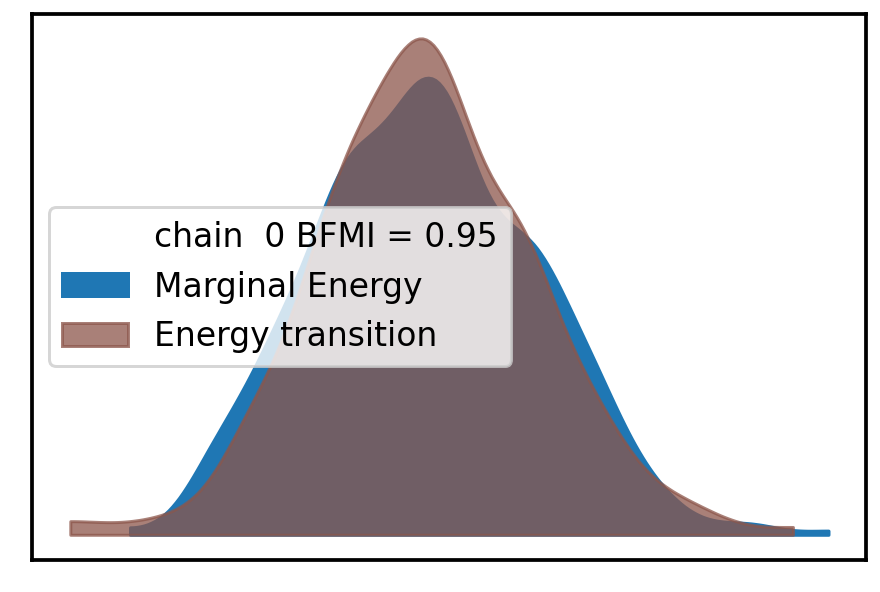

In [73]:
az.plot_energy(trace_r_t_infection_delay)

[Text(0, 0.5, '$R_e(t)$'), Text(0.5, 0, 'Days')]

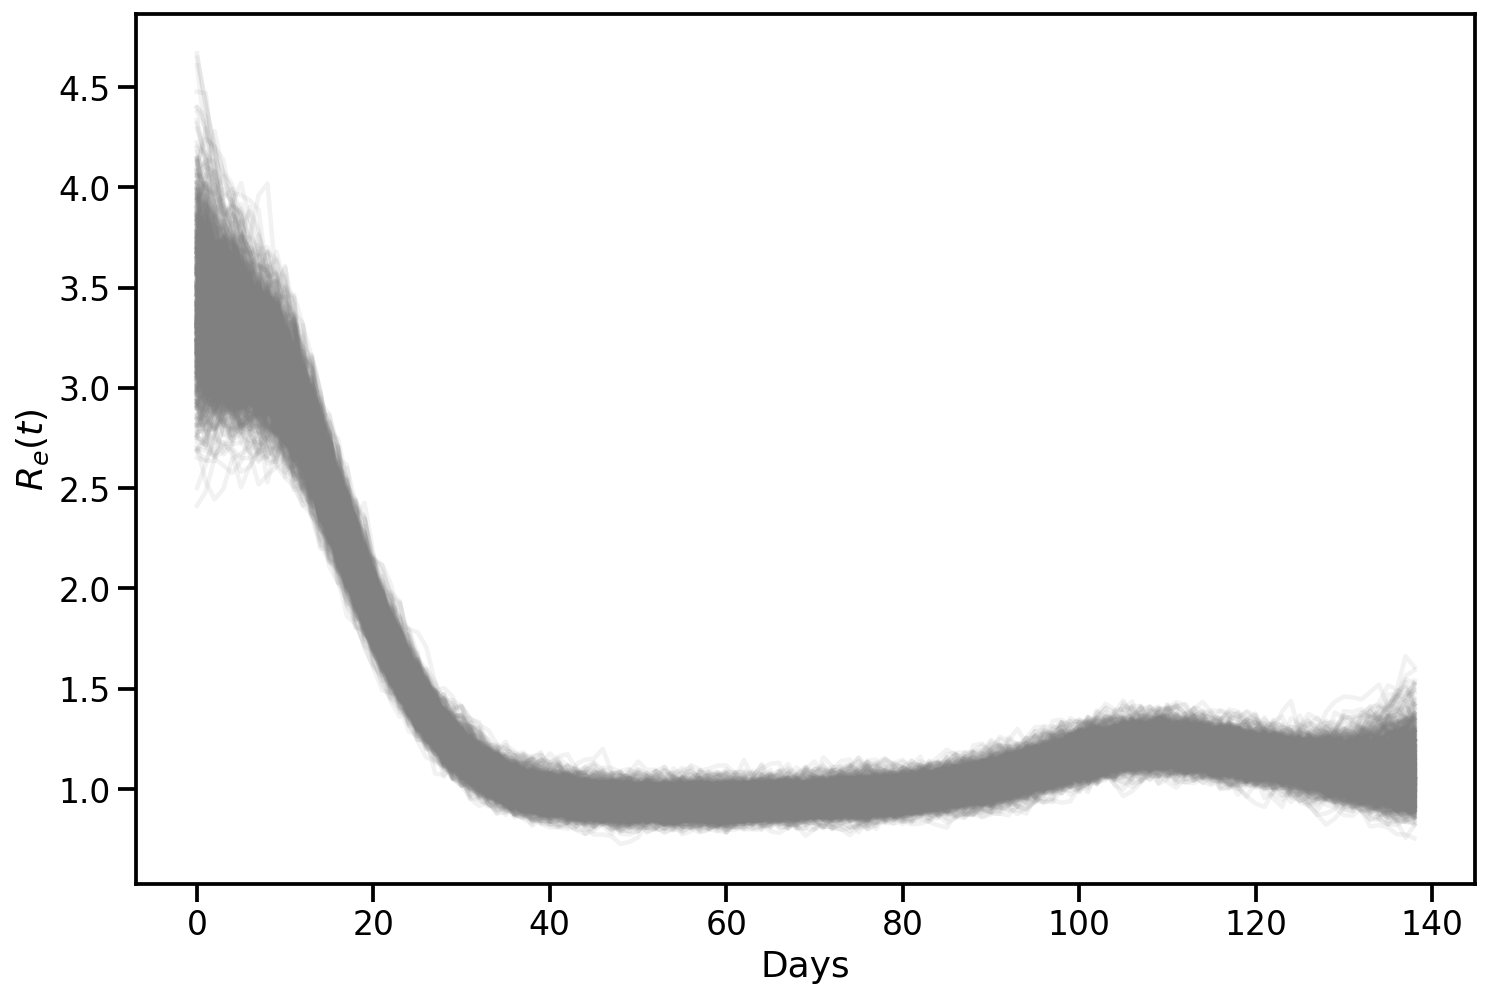

In [74]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(trace_r_t_infection_delay["r_t"].T, color="0.5", alpha=.1);
ax.set(xlabel="Days", ylabel="$R_e(t)$")

#### Posterior predictive

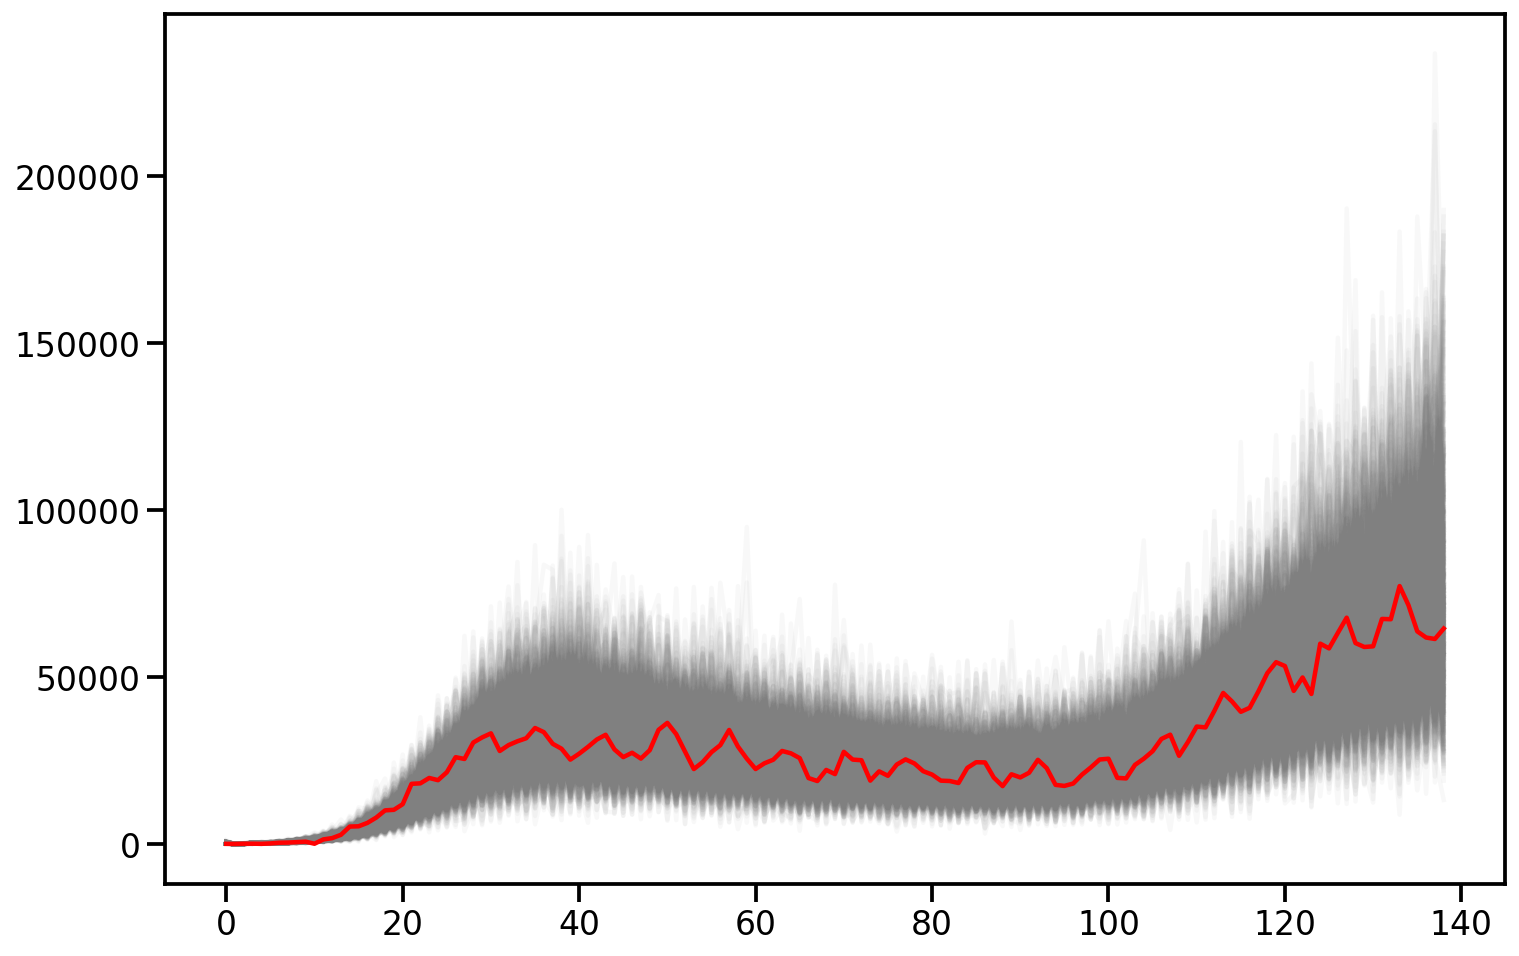

In [75]:
with model_r_t_infection_delay:
    post_pred_r_t_infection_delay = pm.sample_posterior_predictive(trace_r_t_infection_delay)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(post_pred_r_t_infection_delay["obs"].T, color="0.5", alpha=.05);
ax.plot(new_cases.values, color="r");

In [122]:
az.compare({"r_t": trace,
            "r_t_infection_delay": trace_r_t_infection_delay})

/Users/twiecki/miniconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/Users/twiecki/miniconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
r_t_infection_delay,0,-1406.51,16.299,0,1,42.6318,0,True,log
r_t,1,-1606.89,23.4053,200.381,2.28884e-34,21.6503,44.3444,True,log


## Getting to number of infected

So far we have a generative model of how people transmit the disease from one person to the next. However, we don't have data of when people transmitted the disease, we have data of who got a positive test result. So we need to delay this function even further by when an infected patient actually shows up as as a positive test in our data. 

To do this we will use the distribution of the delay between infection and confirmed positive test, also known as the *onset delay distribution*. To estimate this distribution we can use data from the [Open COVID-19 Data Working Group](https://github.com/beoutbreakprepared/nCoV2019) which asked COVID-19 patients how long ago their symptoms started ([Xu et al., 2020](https://www.nature.com/articles/s41597-020-0448-0)). However, symptom onset isn't the same as when someone got infected because there is incubation period during which the virus is spreading in the body while no symptoms are noticeable. To fix this we just an incubation period to the beginning of the *onset delay distribution* ([rt.live](https://rt.live) assumes 5 days). You can see this offset in the flat region from days 1-5 in the next plot. 

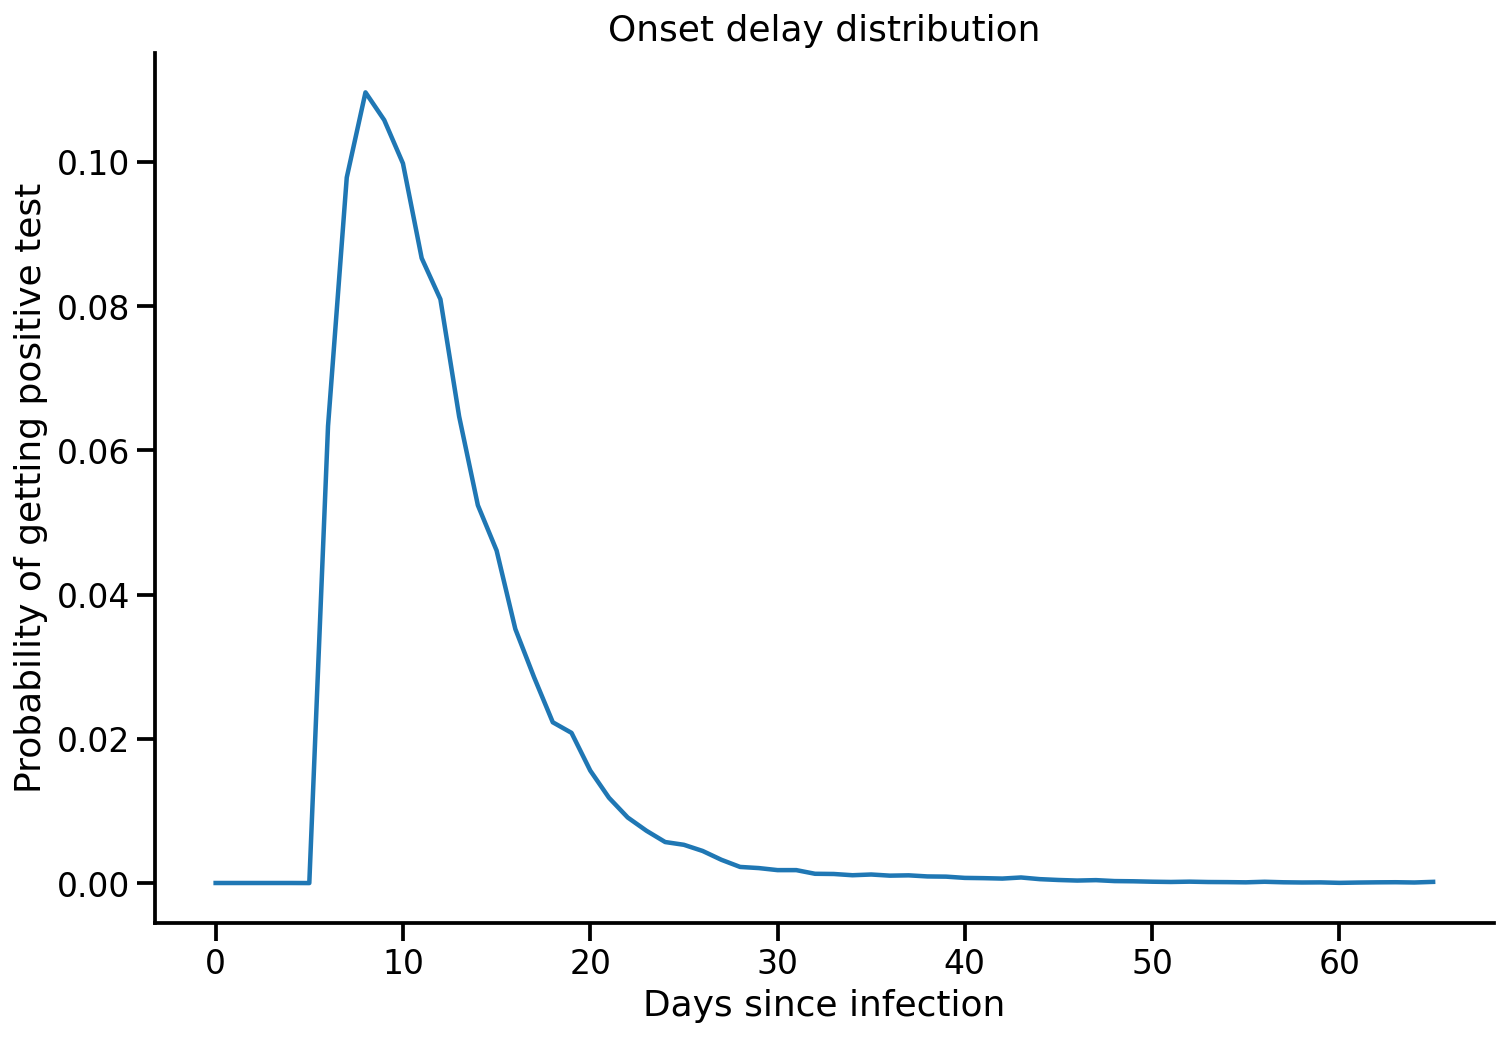

In [132]:
p_delay = get_delay_distribution()
p_delay.iloc[:5] = 1e-5
ax = p_delay.plot(figsize=(12, 8))
ax.set(title="Onset delay distribution", 
       ylabel="Probability of getting positive test", 
       xlabel="Days since infection");
sns.despine();

Now all we need to do is convolve the function we have above of how many people got infected each day with the onset delay distribution to get to how many people will show up with a positive test on that day.

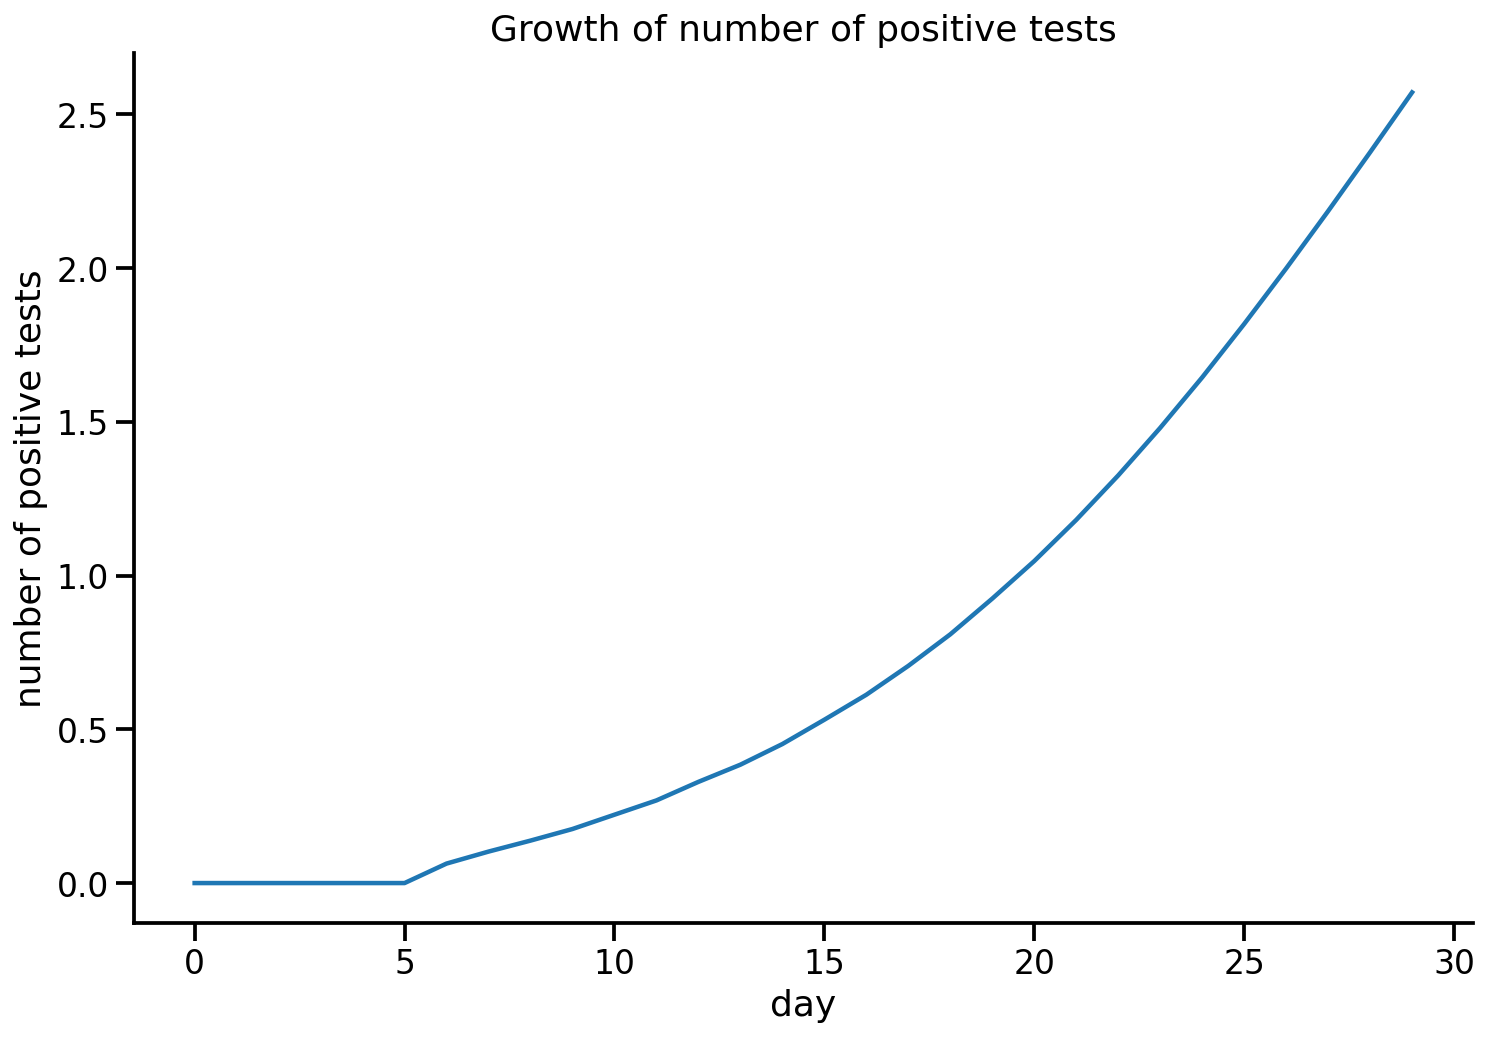

In [133]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ts, np.convolve(y, p_delay)[:n_days])
ax.set(xlabel='day', ylabel='number of positive tests', 
       title='Growth of number of positive tests');
sns.despine();

In [134]:
def conv(a, b, len_observed):
    """Perform a 1D convolution of a and b"""
    from theano.tensor.signal.conv import conv2d
    return conv2d(
            tt.reshape(infections, (1, len_observed)),
            tt.reshape(p_delay, (1, len(p_delay))),
            border_mode="full",
        )[0, :len_observed]

In [135]:
with pm.Model() as model_r_t_onset:
    log_r_t = pm.GaussianRandomWalk(
        "log_r_t",
        sigma=0.035,
        shape=len_observed,
    )
    r_t = pm.Deterministic("r_t", pm.math.exp(log_r_t))

    seed = pm.Exponential("seed", .01)
    y0 = tt.zeros(len_observed)
    y0 = tt.set_subtensor(y0[0], seed)
    outputs, _ = theano.scan(
        fn=lambda t, gt, y, r_t: tt.set_subtensor(y[t], tt.sum(r_t * y * gt)),
        sequences=[tt.arange(1, len_observed), convolution_ready_gt],
        outputs_info=y0,
        non_sequences=r_t,
        n_steps=len_observed - 1,
    )
    infections = pm.Deterministic("infections", outputs[-1])
    
    test_adjusted_positive = pm.Deterministic(
        "test_adjusted_positive",
        conv(infections, p_delay, len_observed)
    )

    # Likelihood
    pm.NegativeBinomial(
        'obs',
        test_adjusted_positive+.1, # first few values are 0, add small offset
        alpha=pm.Gamma("alpha", mu=6, sigma=1),
        observed=new_cases)
    
    prior_pred = pm.sample_prior_predictive()

[(0.0, 100000.0)]

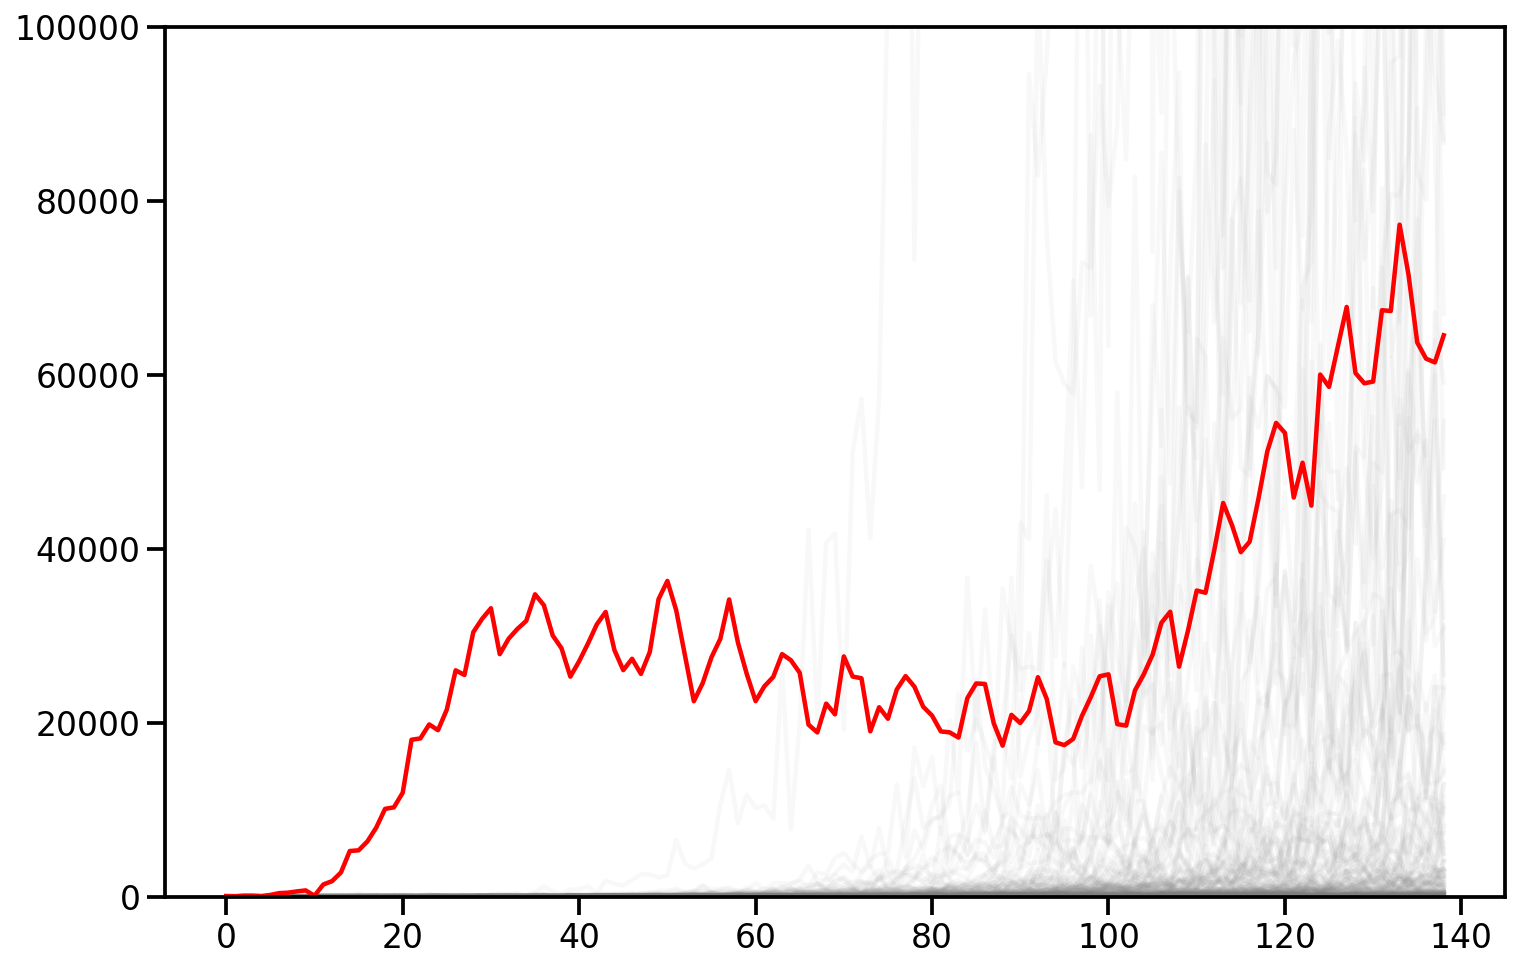

In [136]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(prior_pred["obs"].T, color="0.5", alpha=.05);
ax.plot(new_cases.values, color="r");
ax.set(ylim=(0, 100_000))

In [137]:
with model_r_t_onset:
    trace_r_t_onset = pm.sample(chains=1, cores=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, seed, log_r_t]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1427 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


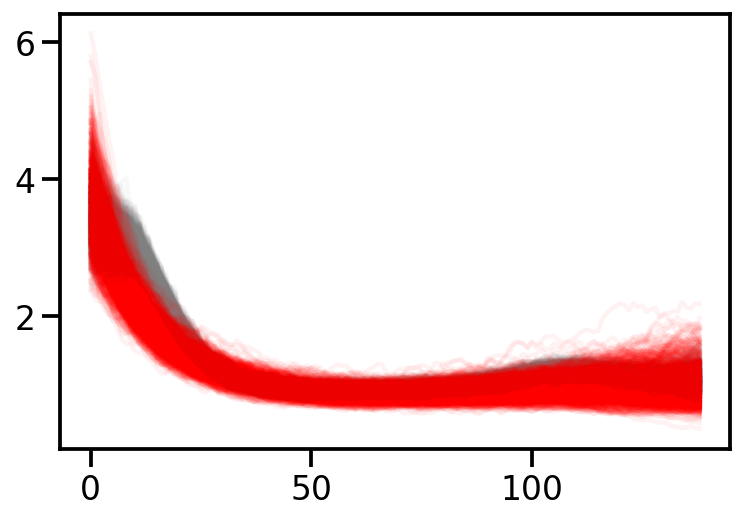

In [138]:
plt.plot(trace_r_t_infection_delay["r_t"].T, color="0.5", alpha=.05);
plt.plot(trace_r_t_onset["r_t"].T, color="r", alpha=.05);

[(0.0, 100000.0)]

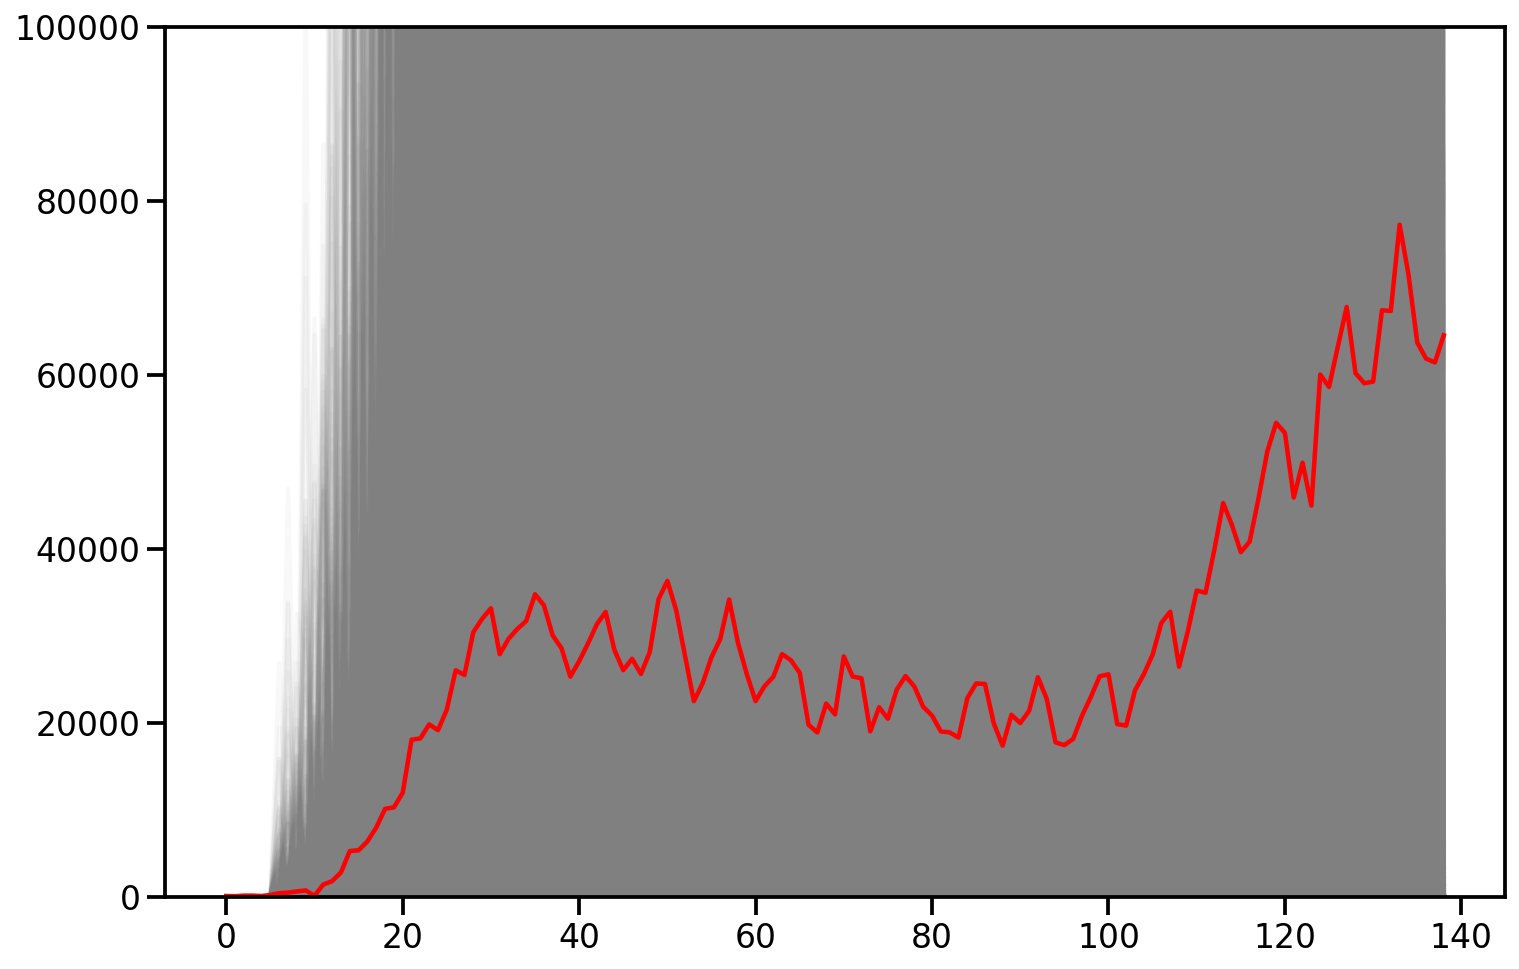

In [150]:
with model_r_t_onset:
    post_pred_r_t_onset = pm.sample_posterior_predictive(trace_r_t_onset)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(post_pred_r_t_onset["obs"].T, color="0.5", alpha=.05);
ax.plot(new_cases.values, color="r");
ax.set(ylim=(0, 100_000))

Unfortunatey that didn't quite work. I'm not sure what is wrong with the model but I left it in here to demonstrate what kind of things you can do inside of a model. Fixing the model is left as an exercise for the motivated reader ;).

In [123]:
az.compare({
    "r_t": trace,
    "infection_delay": trace_r_t_infection_delay,
    "onset": trace_r_t_onset,
})

/Users/twiecki/miniconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/Users/twiecki/miniconda3/envs/bayes_course/lib/python3.7/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
infection_delay,0,-1406.51,16.299,0,NaN,41.2392,0,True,log
r_t,1,-1606.89,23.4053,200.381,NaN,22.595,44.3444,True,log
onset,2,-2043.83,28.5303,637.319,1.17701e-204,75.3198,82.1414,True,log


## Adjusting for number of tests performed

When looking at the number of raw positive tests, it's clear that that number will be influenced by how many people you tested: The more you test, the more cases you will uncover. 

This is important to model because there is huge variability in the number of tests being done over time (ramping up of tests more generally as more testing capacities are created, but also because usually fewer tests are being done on weekends). This would bias our estimate of $R_e(t)$ if not accounted for.

Thus, in the model we multiply the test exposure $e_t$ (a normalized quantity proportional to the number of tests performed) with the number of positive tests from the generative process. Intuitively, if we test twice as much, we expect twice as many positive tests to show up.

Thus, the expected number of positive tests $\tilde{z_t}$ will be:

$$ \tilde{z_t} = z_t \cdot e_t $$

where $z_t$ is the output of the generative model with the delays applied.

## Summarizing the generative process

1. Primary infection occurs (this is the time-point we want Rt to relate to).
2. *Generation time* passes until secondary infection occurs.
3. *Onset time* passes until secondary infected person develops symptoms and tests positive. This is the number of positive tests we'd expect if testing were constant.
4. Multiply number of positive tests (if tests were constant) with the testing exposure to get to the number of expected positives. This is the model output we use to fit the data.

<img src="rtlive_model2.png"/>



## Using the model interactively

Let's see how to actually use the model interactively. As our example region we use Massachusetts. 

In [125]:
df = get_and_process_covidtracking_data(
    run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

region = "MA"
model_data = df.loc[region]

To run the model we just instantiate it and call `.sample()`:

In [128]:
gm = GenerativeModel(region, model_data)
gm.sample(cores=1, chains=1)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, seed, log_r_t]


Sampling 1 chain for 700 tune and 200 draw iterations (700 + 200 draws total) took 784 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


`summarize_inference_data()` reformats the raw sampling trace so that its easier to work with.

In [129]:
result = summarize_inference_data(gm.inference_data)

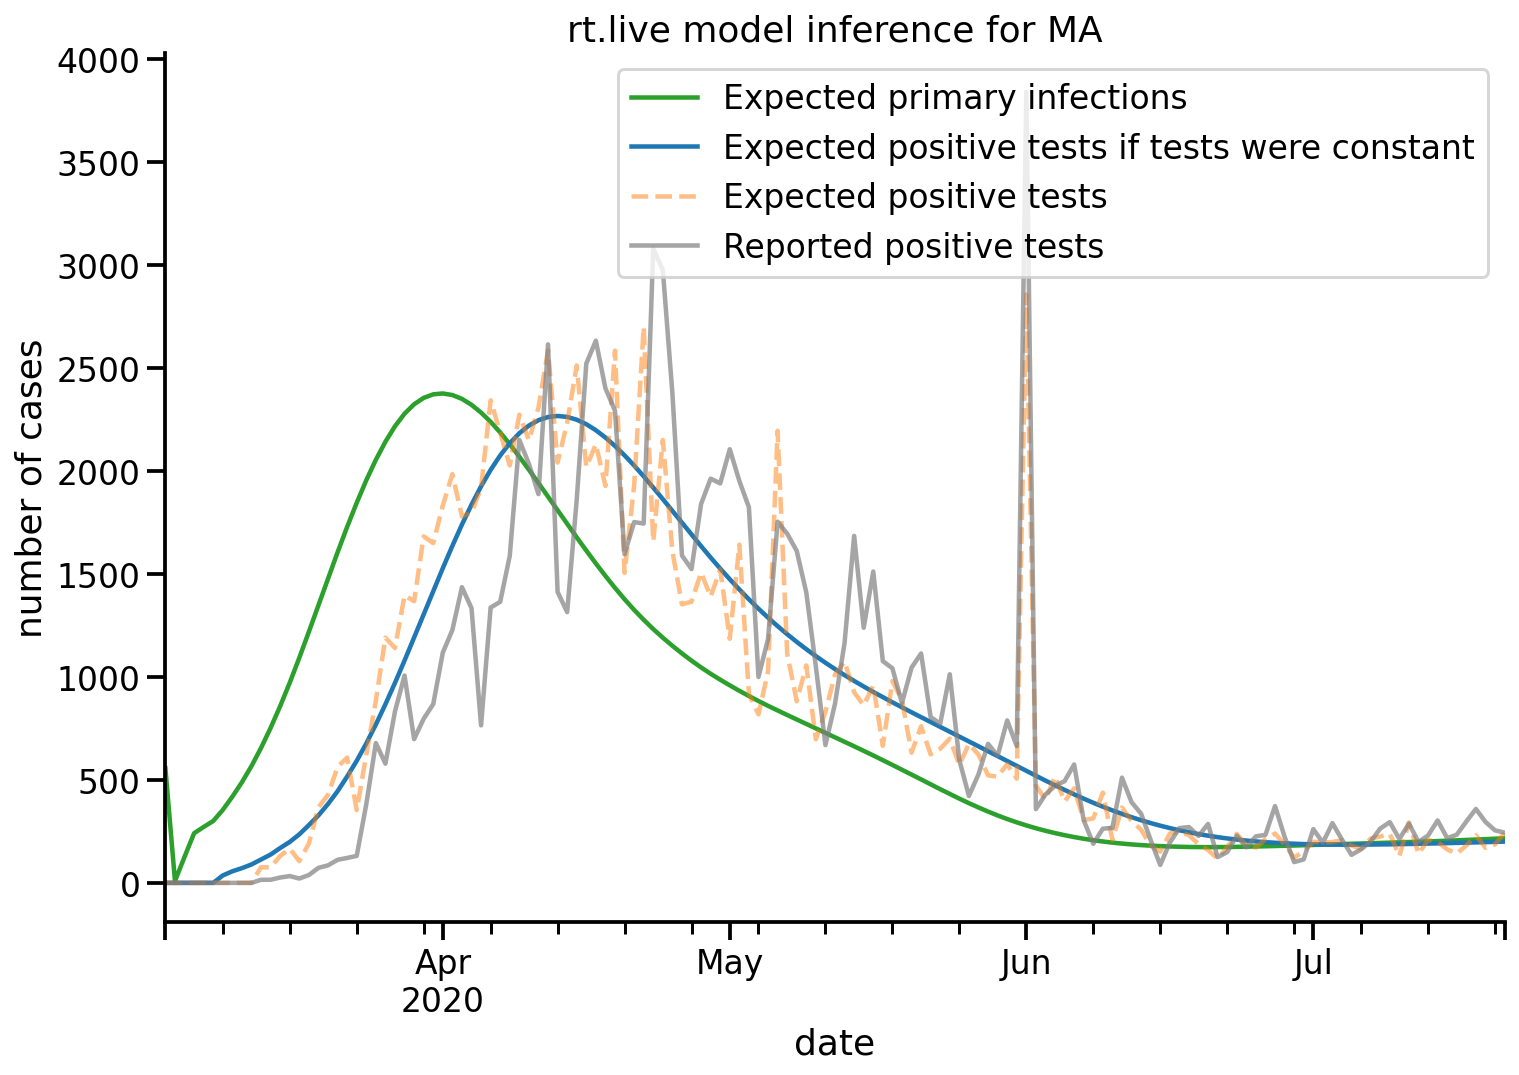

In [130]:
fig, ax = plt.subplots(figsize=(12, 8))
result.infections.plot(c="C2", label="Expected primary infections")
result.test_adjusted_positive.plot(c="C0", label="Expected positive tests if tests were constant")
result.test_adjusted_positive_raw.plot(c="C1", alpha=.5, label="Expected positive tests", style="--")
gm.observed.positive.plot(c="C7", alpha=.7, label="Reported positive tests")
fig.set_facecolor("w")
ax.legend();
ax.set(title=f"rt.live model inference for {region}", ylabel="number of cases")
sns.despine();

The plot above shows exactly what's going on in each step. Let's apply the logic backwards this time, going from data to hidden causes. First, we have the observed data of "Reported positive tests" in grey. This is what our model tries to explain with the "Expected positive tests", the output of the model which is derived from the "Expected number of positive tests if tests were constant". This number we convolve with the *onset delay distribution* to get from to "Infection onset", i.e. when did people actually get infected. From there we use the *generation time distribution* to arrive at when the actual transmission of the disease occured.

Our $R_e(t)$ estimate is then based on when the actual transmission occured, not when we observed the positive test:

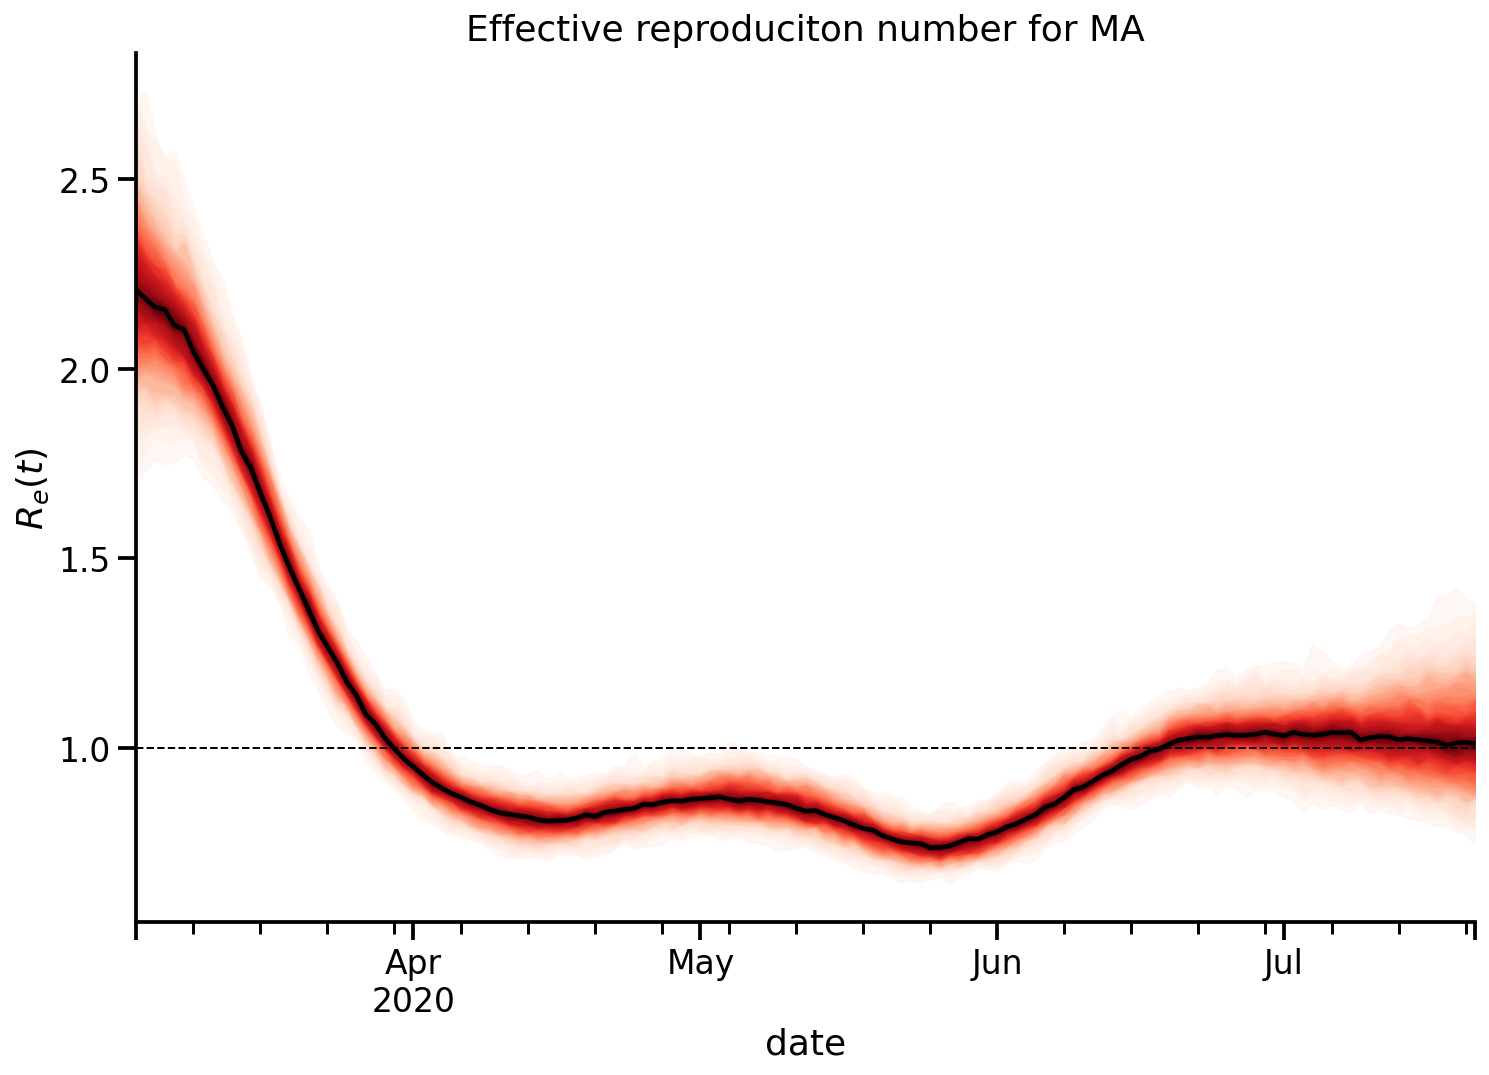

In [131]:
fig, ax = plt.subplots(figsize=(12, 8))
 
ax.set(title=f"Effective reproduciton number for {region}", ylabel="$R_e(t)$")
samples = gm.trace["r_t"]
x = result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
sns.despine();